# **Pipeline de dados do Telegram**

>**Nota**: Criei um grupo somente para realizar os testes, portanto não há quantidades grande de dados na análise. Porém o modelo serve também para grande quantidade de dados!

## **1\. Contexto** 

**Chatbot**

>Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

**Telegram**

>**Telegram** é uma plataforma de mensagens instantâneas **freeware** (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações. 

**Arquitetura** 

>Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um chatbot para responder perguntas como:

    1. Qual o horário que os usuários mais acionam o *bot*?
    1. Qual o problema ou dúvida mais frequente?
    1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
    1. Etc.
    
>Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

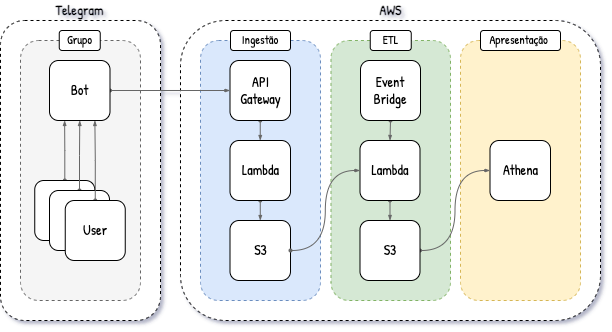

## **2\. Wrangling** 

>Na etapa de **ingestão**, o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo **bot** do **Telegram** em um **bucket** do `AWS S3`. Para tanto vamos criar uma função que opera da seguinte forma:

     - Recebe a mensagem no parâmetro `event`;
     - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
     - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
     - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**. 

**ETL**

>A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

In [ ]:
# O código da função dos dados raw

import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

In [ ]:
# Código dos dados enriched
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
# Código de Wrangling

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

>**Nota**: Dessa maneira os dados têm um atraso de 24 horas, que não é um problema para fins analíticos! 

## **3\. Data Analysis**

**Usaremos o serviço da AWS *Athena* para realizar as análises!**

>Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

- Quantidade de usuários.

```sql
SELECT 
    COUNT(user_id) AS QTD_CLIENTES
FROM "telegram"
```

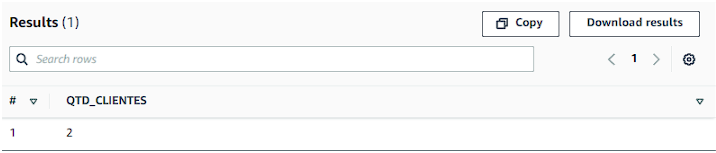

- Quantidade de mensagens por dia.

```sql
SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC
```

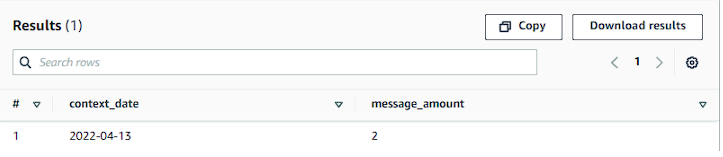


- Quantidade de mensagens por usuário por dia.

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

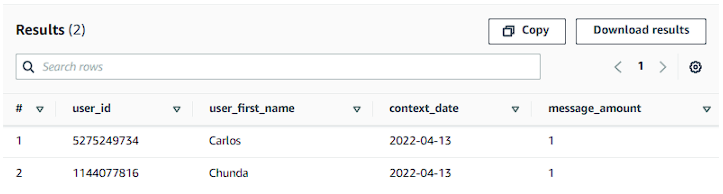

- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

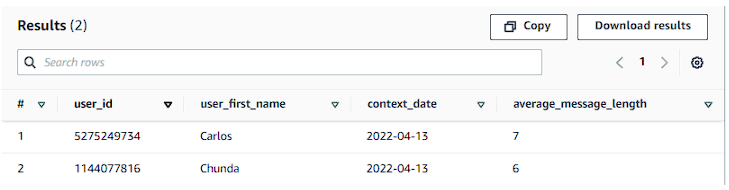

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH 
parsed_date_cte AS (
    SELECT 
        *, 
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram" 
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount" 
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

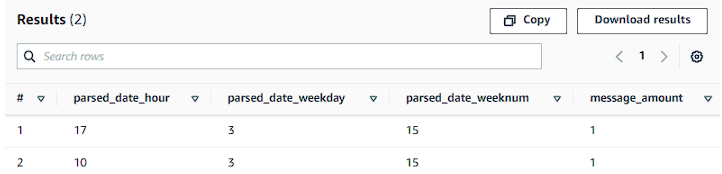

## **4\. Apresentação**

>**Dashboard** de apresentação dos dados:
https://datastudio.google.com/reporting/b7398433-45b2-42ea-b081-eb3492d3ac2c